In [ ]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [16]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
from azure.storage.blob import ContainerClient
import matplotlib.pyplot as plt

load_dotenv()
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
AA_DATA_DIR = Path(os.getenv("AA_DATA_DIR"))
AA_DATA_DIR_NEW = Path(os.getenv("AA_DATA_DIR_NEW"))

DEV_BLOB_SAS = os.getenv("DSCI_AZ_SAS_DEV")
DEV_BLOB_NAME = "imb0chd0dev"
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
DEV_BLOB_PROJ_URL = DEV_BLOB_URL + "projects" + "?" + DEV_BLOB_SAS
GLOBAL_CONTAINER_NAME = "global"
DEV_BLOB_GLB_URL = DEV_BLOB_URL + GLOBAL_CONTAINER_NAME + "?" + DEV_BLOB_SAS

dev_glb_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

## 1. Loading in raw data

In [17]:
emdat_path = (
    AA_DATA_DIR_NEW
    / "private"
    / "processed"
    / "glb"
    / "emdat"
    / "emdat-tropicalcyclone-2000-2022-processed-sids.csv"
)

ibtracs_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "glb"
    / "ibtracs"
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

adm1_path = (
    AA_DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)

In [22]:
df_emdat = pd.read_csv(emdat_path)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_ibtracs = gpd.read_file(ibtracs_path)

Clean up EM-DAT data to get list of impactful cyclones that hit landfall in our AOI in Mozambique. Combine with IBTrACS data.

In [51]:
df_emdat_sel = df_emdat[df_emdat.iso3 == "MOZ"]

gdf_hist = gdf_ibtracs.merge(df_emdat_sel, left_on="SID", right_on="sid", how="right")

gdf_hist = gdf_hist[
    ["SID", "NAME", "Total Affected", "ISO_TIME", "REU_WIND", "geometry"]
].sort_values(by="Total Affected")

df_impact_summary = (
    gdf_hist.groupby(["SID", "NAME"]).max("Total Affected").reset_index()
)

In [52]:
# TODO: Split up by province
df_impact_summary

,SID,NAME,Total Affected,REU_WIND
0,2000032S11116,ELINE:LEONE,NaN,100.0
1,2000083S17102,HUDAH,304.0,120.0
2,2003056S21042,JAPHET,23010.0,95.0
3,2007043S11071,FAVIO,162770.0,105.0
4,2008062S10064,JOKWE,220013.0,105.0
5,2009082S16039,IZILDA,7103.0,60.0
6,2012010S24049,DANDO,40042.0,45.0
7,2012018S16041,FUNSO,65000.0,110.0
8,2012056S13057,IRINA,4958.0,52.0
9,2017043S19040,DINEO,750102.0,75.0


In [ ]:
# TODO: Interpolate IBTrACS points

#gdf_ibtracs["time"] = pd.to_datetime(gdf_ibtracs["ISO_TIME"])
#for sid, group in gdf_ibtracs.groupby("SID"):
#    print(sid)
#    df_interp = group.set_index("time").resample("30min").interpolate().reset_index()

Now load in the precipitation data from the processed IMERG files

In [56]:
imerg_path = (
    Path(AA_DATA_DIR) / "public" / "processed" / "moz" / "daily_imerg_precip_adm1.csv"
)

# TODO: Take the 2-day rolling sum?
df_imerg = pd.read_csv(imerg_path)
df_imerg_sel = df_imerg[df_imerg.ADM1.isin(ADMS)]

Create a simple plot to sanity check

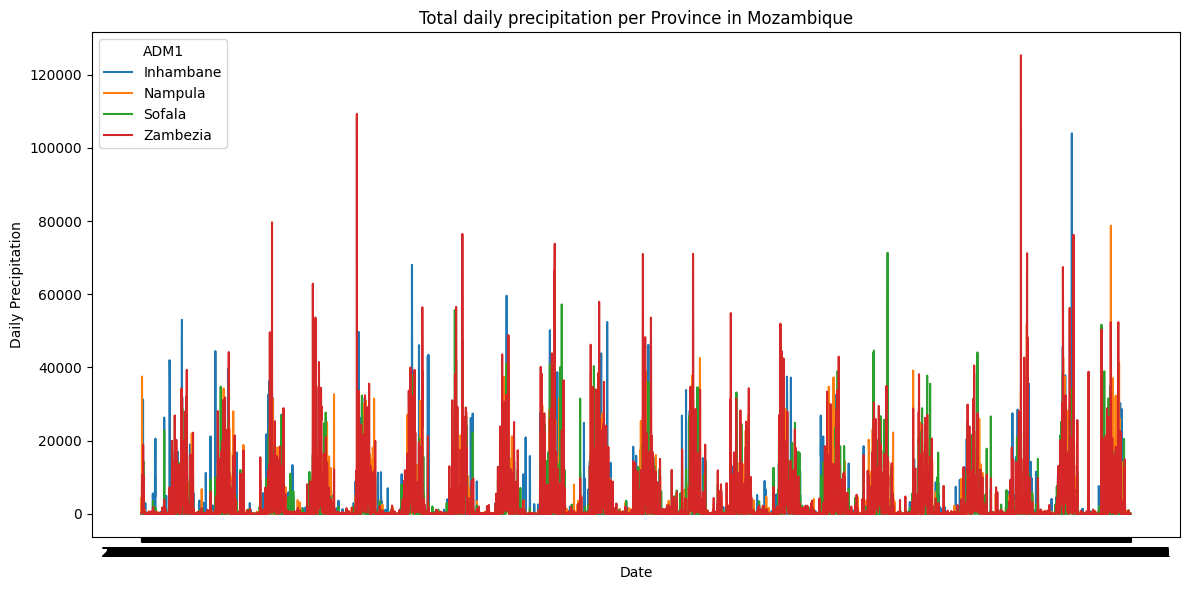

In [58]:
plt.figure(figsize=(12, 6))

# Group by ADM1 and plot each group
for adm1, group in df_imerg_sel.groupby("ADM1"):
    plt.plot(group["date"], group["total_precipitation"], label=adm1)

plt.xlabel("Date")
plt.ylabel("Daily Precipitation")
plt.title("Total daily precipitation per Province in Mozambique")
plt.legend(title="ADM1")
plt.tight_layout()
plt.grid(False)
plt.show()